<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/ModelRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install firebase-admin
from google.colab import drive 
drive.mount('/content/drive')
import firebase_admin
import cv2 
from firebase_admin import credentials,db 
from google.colab.patches import cv2_imshow
from sklearn.externals import joblib 
from firebase_admin import storage 
import pandas as pd 
import csv 
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

In [0]:
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

IMAGE GENERATION 

TAKING SHANGHAI'S DATA and Labels 


In [18]:
!unzip '/content/drive/My Drive/shanghai.zip'

Archive:  /content/drive/My Drive/shanghai.zip
replace 201405071100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Q
error:  invalid response [Q]
replace 201405071100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [19]:
##GETTING NAMES  -- ##Location - SSCB and DTU : Rotated images  

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
     
      
    

lenovo2019-06-27 17:05:48.jpeg
lenovo2019-06-27 17:10:27.jpeg
lenovo2019-06-27 17:15:58.jpeg
lenovo2019-06-27 18:04:29.jpeg
lenovo2019-06-27 18:08:53.jpeg
lenovo2019-06-27 18:17:05.jpeg
lenovo2019-06-27 18:19:07.jpeg
lenovo2019-06-27 18:26:07.jpeg
lenovo2019-06-27 18:28:53.jpeg
lenovo2019-06-27 18:35:27.jpeg
lenovo2019-06-27 18:39:31.jpeg
lenovo2019-06-27 18:47:06.jpeg
lenovo2019-06-27 18:49:07.jpeg
lenovo2019-06-27 18:56:06.jpeg
lenovo2019-06-28 06:00:07.jpeg
lenovo2019-06-28 06:04:07.jpeg
lenovo2019-06-28 06:09:28.jpeg
lenovo2019-06-28 06:14:37.jpeg
lenovo2019-06-28 06:18:53.jpeg
lenovo2019-06-28 06:25:28.jpeg
lenovo2019-06-28 06:29:29.jpeg
lenovo2019-06-28 06:35:27.jpeg
lenovo2019-06-28 06:38:53.jpeg
lenovo2019-06-28 06:44:28.jpeg
lenovo2019-06-28 06:49:29.jpeg
lenovo2019-06-28 06:56:37.jpeg
lenovo2019-06-28 07:00:28.jpeg
lenovo2019-06-28 07:04:07.jpeg
lenovo2019-06-28 07:09:28.jpeg
lenovo2019-06-28 07:13:53.jpeg
lenovo2019-06-28 07:18:53.jpeg
lenovo2019-06-28 07:23:53.jpeg
lenovo20

In [0]:
##READING THEM 

dtu=[]
sscb=[]
for img in imglenovo:
  if(img[11:16]>'07-02'):##These indicate the DTU Images - which need to be cropped and rotated 
    l=[]
    l.append(img)
    im = cv2.imread(img)
    crop = im[700:3150, 0:3120]
    crop = cv2.resize(crop, (int(np.shape(im)[1]*0.1), int(np.shape(im)[0]*0.1)))
    im = cv2.resize(crop,(256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    dtu.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)           ##These indicate the SSCB Images - rotation only 
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
    l.append(im)
    sscb.append(l)
    
    
    

In [21]:
## CHECKING BLOCK 

print(len(dtu))
print(len(sscb))


369
502


In [22]:
##GETTING NAMES - PUNJABI BAGH 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgpb = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="rivers.jpg" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgpb.append("pb" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        

pb2019-07-03 12:46:45.jpeg
pb2019-07-03 12:47:33.jpeg
pb2019-07-03 12:48:16.jpeg
pb2019-07-03 12:49:38.jpeg
pb2019-07-03 12:50:40.jpeg
pb2019-07-03 12:51:46.jpeg
pb2019-07-03 12:52:29.jpeg
pb2019-07-03 12:53:54.jpeg
pb2019-07-03 12:54:57.jpeg
pb2019-07-03 12:56:00.jpeg
pb2019-07-03 12:57:00.jpeg
pb2019-07-03 12:58:01.jpeg
pb2019-07-03 12:58:16.jpeg
pb2019-07-03 12:59:16.jpeg
pb2019-07-03 13:01:35.jpeg
pb2019-07-03 13:02:57.jpeg
pb2019-07-03 13:03:59.jpeg
pb2019-07-03 13:04:14.jpeg
pb2019-07-03 13:05:00.jpeg
pb2019-07-03 13:05:27.jpeg
pb2019-07-03 13:06:00.jpeg
pb2019-07-03 13:06:42.jpeg
pb2019-07-03 13:08:00.jpeg
pb2019-07-03 13:08:58.jpeg
pb2019-07-03 13:10:17.jpeg
pb2019-07-03 13:11:18.jpeg
pb2019-07-03 13:12:19.jpeg
pb2019-07-03 13:13:35.jpeg
pb2019-07-03 13:14:22.jpeg
pb2019-07-03 13:15:24.jpeg
pb2019-07-03 13:16:25.jpeg
pb2019-07-03 13:17:26.jpeg
pb2019-07-03 13:18:21.jpeg
pb2019-07-03 13:19:27.jpeg
pb2019-07-03 13:20:27.jpeg
pb2019-07-03 13:21:27.jpeg
pb2019-07-03 13:22:28.jpeg
p

In [0]:
##READING IMAGES - Rotated

pb=[]
for img in imgpb:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im, (256,256))
  im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
  l.append(im)
  pb.append(l)


In [24]:
##GETTING NAMES - Location : DTU AND SHADIPUR 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        
      


minote2019-06-27 16:42:56.jpeg
minote2019-06-27 16:49:53.jpeg
minote2019-06-27 16:50:47.jpeg
minote2019-06-27 16:51:15.jpeg
minote2019-06-27 16:54:37.jpeg
minote2019-06-27 16:59:33.jpeg
minote2019-06-27 17:04:38.jpeg
minote2019-06-27 17:05:00.jpeg
minote2019-06-27 17:09:17.jpeg
minote2019-06-27 17:14:39.jpeg
minote2019-06-27 17:19:17.jpeg
minote2019-06-27 17:24:39.jpeg
minote2019-06-27 17:29:17.jpeg
minote2019-06-27 17:37:58.jpeg
minote2019-06-27 17:39:17.jpeg
minote2019-06-27 17:46:28.jpeg
minote2019-06-27 17:49:20.jpeg
minote2019-06-27 17:54:17.jpeg
minote2019-06-27 18:01:16.jpeg
minote2019-06-27 18:05:04.jpeg
minote2019-06-27 18:09:35.jpeg
minote2019-06-27 18:14:59.jpeg
minote2019-06-27 18:19:18.jpeg
minote2019-06-27 18:24:40.jpeg
minote2019-06-27 18:29:18.jpeg
minote2019-06-27 18:35:06.jpeg
minote2019-06-27 18:39:38.jpeg
minote2019-06-27 18:47:35.jpeg
minote2019-06-27 18:49:17.jpeg
minote2019-06-27 18:54:39.jpeg
minote2019-06-27 18:59:28.jpeg
minote2019-06-28 06:02:35.jpeg
minote20

In [0]:
##READING IMAGES - Location - SSCB and SHADIPUR ; Rotation 
shadipur = []
for img in imgminote : 
  if(img[11:16]>'07-05'):  ##Shadipur images needed rotating  
    l=[]
    l.append(img)
    im = cv2.imread(img)
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    shadipur.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)               ##SSCB images did not need any rotating 
    im = cv2.resize(im, (256,256))
    l.append(im)
    sscb.append(l)
    

In [26]:
print(len(shadipur))
print(len(sscb))

244
1320


In [31]:
bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imgito = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:17]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
      imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
     


ito2019-06-11 18:17:24.jpeg
ito2019-06-11 18:20:06.jpeg
ito2019-06-11 18:28:35.jpeg
ito2019-06-11 18:29:32.jpeg
ito2019-06-11 18:34:36.jpeg
ito2019-06-11 18:39:46.jpeg
ito2019-06-11 18:45:29.jpeg
ito2019-06-11 18:49:32.jpeg
ito2019-06-11 18:57:32.jpeg
ito2019-06-12 06:01:32.jpeg
ito2019-06-12 06:08:07.jpeg
ito2019-06-12 06:11:30.jpeg
ito2019-06-12 06:18:41.jpeg
ito2019-06-12 06:23:17.jpeg
ito2019-06-12 06:26:27.jpeg
ito2019-06-12 06:31:27.jpeg
ito2019-06-12 06:36:27.jpeg
ito2019-06-12 06:41:38.jpeg
ito2019-06-12 06:46:48.jpeg
ito2019-06-12 06:52:07.jpeg
ito2019-06-12 06:56:47.jpeg
ito2019-06-12 07:01:27.jpeg
ito2019-06-12 07:07:37.jpeg
ito2019-06-12 07:12:14.jpeg
ito2019-06-12 07:18:25.jpeg
ito2019-06-12 07:24:26.jpeg
ito2019-06-12 07:26:27.jpeg
ito2019-06-12 07:34:47.jpeg
ito2019-06-12 07:36:27.jpeg
ito2019-06-12 07:42:07.jpeg
ito2019-06-12 07:48:07.jpeg
ito2019-06-12 07:52:07.jpeg
ito2019-06-12 07:58:27.jpeg
ito2019-06-12 08:01:40.jpeg
ito2019-06-12 08:08:48.jpeg
ito2019-06-12 08:11:

In [0]:
##READING BLOCK 

ito=[]

for img in imgito:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im,(256,256))
  im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
  l.append(im)
  ito.append(l)


In [0]:
print(len(ito))
print(ito[0])

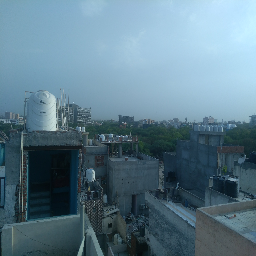

In [38]:
cv2_imshow(ito[0][1])

In [0]:
## Concatenating Shanghai's data 
import os
shanghai={}
source = os.listdir('/content/')
for file in source:
  if(file[:4]=='2014'):
    im = cv2.imread('/content/' + file)
    im = cv2.resize(im,(256,256))
    l=[]
    l.append(file[8:10])
    l.append(trans_deg(im))
    l.append(entropy(im))
    l.append(contrast(im))
    shanghai[file]=l
    
    

In [68]:
print(np.shape(sscb))    
print(np.shape(ito))      
print(np.shape(dtu))  
print(np.shape(shadipur))     
print(np.shape(pb))    
print(np.shape(shanghai))



(1320, 2)
(499, 2)
(369, 2)
(244, 2)
(483, 2)
()


LABEL PROCESSING 

In [0]:
##SSCB 
df = pd.read_csv('/content/sscb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/sscb_labels_new.csv')

k=0
cpcb=[]

with open('/content/sscb_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [197]:
print(len(cpcb))

698


In [0]:
##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in sscb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  
  

In [199]:
feat=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
#       imc = date[2]
#       imc = cv2.resize(imc, (64,64))
      l=[]
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)
      
   

minote2019-06-27 16:54:37.jpeg
   -   -  ['27-06-2019 16:00', 0.2370663558652809, 5.071457862854004, 2.468056791148552, '47']
minote2019-06-27 16:59:33.jpeg
   -   -  ['27-06-2019 16:00', 0.2249426478557362, 40.19698715209961, 59.820981855775706, '47']
minote2019-06-27 16:42:56.jpeg
   -   -  ['27-06-2019 16:45', 0.3172220096162712, 41.98408126831055, 60.822207739303735, '47']
minote2019-06-27 16:49:53.jpeg
   -   -  ['27-06-2019 16:45', 0.25359132621390035, 5.048366069793701, 2.470456806162675, '47']
minote2019-06-27 16:50:47.jpeg
   -   -  ['27-06-2019 16:45', 0.3288283642008684, 42.25675964355469, 62.17865647994067, '47']
minote2019-06-27 16:51:15.jpeg
   -   -  ['27-06-2019 16:45', 0.28207587394584605, 45.038902282714844, 57.058971414239934, '47']
lenovo2019-06-27 17:05:48.jpeg
   -   -  ['27-06-2019 17:00', 0.2591012103002101, 38.31585693359375, 63.26486441079081, '45']
minote2019-06-27 17:04:38.jpeg
   -   -  ['27-06-2019 17:00', 0.30990372448446485, 42.740291595458984, 64.309044

In [200]:
print(len(feat))

1157


In [0]:

df = pd.read_csv('/content/dtu_labels.csv')

data = df.mask(df.eq('None')).dropna()

file = data.to_csv('/content/dtu_labels_new.csv')

k=0

cpcb=[]

with open('/content/dtu_labels_new.csv') as file:

  reader = csv.reader(file, delimiter =',')

  for row in reader:

    k+=1

    if(k>3):

      l=[]

      l.append(row[1]) #DATE 

      l.append(row[3]) #PM

      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 


m_tmp=[]
for tmp in dtu:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  

In [203]:
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
#       imc = date[2]
#       imc = cv2.resize(imc, (64,64))
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)
      

lenovo2019-07-03 16:54:58.jpeg
   -   -  ['03-07-2019 16:00', 0.27104453670059053, 43.94867706298828, 86.06920885429538, '28.14']
lenovo2019-07-03 16:09:45.jpeg
   -   -  ['03-07-2019 16:15', 0.2593522846110299, 44.03278732299805, 85.93560556766379, '29.15']
lenovo2019-07-03 16:14:59.jpeg
   -   -  ['03-07-2019 16:15', 0.2688474605592182, 46.8581428527832, 83.35990418815406, '29.15']
lenovo2019-07-03 16:20:22.jpeg
   -   -  ['03-07-2019 16:15', 0.27173419667827103, 47.97339630126953, 81.99809791194996, '29.15']
lenovo2019-07-03 16:25:16.jpeg
   -   -  ['03-07-2019 16:30', 0.26303766315013194, 48.050804138183594, 82.01107310915145, '29.15']
lenovo2019-07-03 16:30:07.jpeg
   -   -  ['03-07-2019 16:30', 0.2647086370439017, 47.41930389404297, 83.83208922627172, '29.15']
lenovo2019-07-03 16:37:18.jpeg
   -   -  ['03-07-2019 16:30', 0.2558922851057147, 47.60153579711914, 82.05574609291989, '29.15']
lenovo2019-07-03 16:43:24.jpeg
   -   -  ['03-07-2019 16:45', 0.26824649647003634, 46.58362197

In [204]:
print(len(feat))

1526


In [0]:
## PUNJABI BAGH 

df = pd.read_csv('/content/pb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/labels_pb_new.csv')


k=0
cpcb=[]

with open('/content/labels_pb_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 

m_tmp=[]
for tmp in pb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)   

In [207]:
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
#       imc = date[2]
#       imc = cv2.resize(imc,(64,64))
      #l.append(transmission(im,retMean=True))
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)

pb2019-07-03 12:53:54.jpeg
   -   -  ['03-07-2019 12:00', 0.35262537716858333, 43.27198028564453, 71.79568436486677, '48.3']
pb2019-07-03 12:54:57.jpeg
   -   -  ['03-07-2019 12:00', 0.3761433881143876, 44.84650421142578, 73.70845157017446, '48.3']
pb2019-07-03 12:56:00.jpeg
   -   -  ['03-07-2019 12:00', 0.34732869548400397, 45.55087661743164, 73.23119520079827, '48.3']
pb2019-07-03 12:57:00.jpeg
   -   -  ['03-07-2019 12:00', 0.3721619955581045, 44.28897476196289, 71.77747304691782, '48.3']
pb2019-07-03 12:58:01.jpeg
   -   -  ['03-07-2019 12:00', 0.3445363241519527, 43.99489212036133, 71.24182355357836, '48.3']
pb2019-07-03 12:58:16.jpeg
   -   -  ['03-07-2019 12:00', 0.3474709018423272, 42.79534912109375, 70.60830628406069, '48.3']
pb2019-07-03 12:59:16.jpeg
   -   -  ['03-07-2019 12:00', 0.3497284679547335, 42.171913146972656, 69.92715933606851, '48.3']
pb2019-07-03 12:46:45.jpeg
   -   -  ['03-07-2019 12:45', 0.33461393883922336, 44.660099029541016, 73.25442309323716, '46']
pb201

In [208]:

print(len(feat))

2009


In [0]:
## ITO 
# df_ = pd.read_csv('/content/ito_labels.csv')
# data_ = df_.mask(df_.eq('None')).dropna()
# file_ = data_.to_csv('/content/ito_labels_new.csv')


# k=0
# cpcb=[]

# with open('/content/ito_labels_new.csv') as file:
#   reader = csv.reader(file, delimiter =',')
#   for row in reader:
#     k+=1
#     if(k>3):
#       l=[]
#       l.append(row[1]) #DATE 
#       l.append(row[3]) #PM
#       cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 
# m_tmp=[]
# for tmp in ito:
#   l=[]
#   temp=tmp[0]
#   temp=temp[-24:-5]
#   temp=temp.split('-')
#   newtemp=temp[2].split(' ')
#   newesttemp=newtemp[1].split(':')
#   j=int(newesttemp[1])
#   #print(j)
#   if(j<=7.5):
#     final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
#   elif(j<=15 or j<=22.5):
#     final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
#   elif(j<=30 or j<=37.5):
#     final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
#   elif(j<=45 or j<=52.5):
#     final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
#   elif(j>52.5):
#     final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
#   l.append(tmp[0])
#   l.append(final)
#   l.append(tmp[1])
#   m_tmp.append(l) 

In [0]:
# for val in cpcb:
#   for date in m_tmp:
#     if(val[0] == date[1]):
#       print(date[0])
#       im = date[2]
#       l=[]
#       l.append(val[0])
#       l.append(trans_deg(im))
#       l.append(entropy(im))
#       l.append(contrast(im))
#       l.append(val[1])
#       print('   -   -  ' + str(l))
#       feat.append(l)

In [209]:
print(len(feat))

2009


In [0]:
## SHADIPUR 

df_ = pd.read_csv('/content/shadipur_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/shadipur_labels_new.csv')


k=0
cpcb=[]

with open('/content/shadipur_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [211]:
print(len(cpcb))

418


In [0]:

##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in shadipur:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) 
 

In [213]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)

minote2019-07-06 06:02:51.jpeg
   -   -  ['06-07-2019 06:00', 0.28168869105317984, 51.09196472167969, 79.54891514830013, '65.12']
minote2019-07-06 06:56:50.jpeg
   -   -  ['06-07-2019 06:00', 0.28594229743915156, 51.513912200927734, 78.68497408220485, '65.12']
minote2019-07-06 06:08:02.jpeg
   -   -  ['06-07-2019 06:15', 0.28665492961296785, 50.78607177734375, 79.7805814016487, '66.88']
minote2019-07-06 06:12:35.jpeg
   -   -  ['06-07-2019 06:15', 0.2752922708258897, 49.60020446777344, 79.15512153350036, '66.88']
minote2019-07-06 06:16:49.jpeg
   -   -  ['06-07-2019 06:15', 0.27945672865375776, 49.743465423583984, 78.35325558384844, '66.88']
minote2019-07-06 06:22:35.jpeg
   -   -  ['06-07-2019 06:15', 0.285269123161142, 49.66383743286133, 78.92879896008706, '66.88']
minote2019-07-06 06:27:54.jpeg
   -   -  ['06-07-2019 06:30', 0.2885789093504458, 49.48595428466797, 79.46126001917587, '66.88']
minote2019-07-06 06:32:35.jpeg
   -   -  ['06-07-2019 06:30', 0.2809699872321486, 47.55215072

In [214]:
print(len(feat))

2253


In [215]:
print(feat[0][0])
#print(shanghai['201412091015.jpg'])


new_shanghai=[]

for key in shanghai:

  temp = key 
  temp = temp[6:8] + '-' + temp[4:6] + '-' + temp[0:4] + ' ' + temp[8:10] + ':' + temp[10:12]
  l=[]
  l.append(temp)
  l.append(shanghai[key][1])
  l.append(shanghai[key][2])
  l.append(shanghai[key][3])
  new_shanghai.append(l)
  

27-06-2019 16:00


In [0]:
## Attaching labels 
shanghai_labels={}
with open('/content/shanghai_labels_regressor.csv') as file :
  read = csv.reader(file)
  for row in read:
    #if (row[1]!='4' and row[1]!='5' and row[1]!='6' and row[1]!='7' and row[1]!='8' and row[1]!='9'):
    if(len(row[1])==1):
      row[1]='0' + row[1]
    if(len(row[2])==1):
      row[2]='0' + row[2]
    if(len(row[3])==1):
      row[3]='0' + row[3]
    temp = row[2] + '-' + row[1] + '-' + row[0] + ' ' +row[3] + ':' + '00'

    shanghai_labels[temp]=row[5]
    

In [217]:
print(shanghai_labels)



{'01-01-2014 00:00': '136', '01-01-2014 01:00': '173', '01-01-2014 02:00': '166', '01-01-2014 03:00': '157', '01-01-2014 04:00': '157', '01-01-2014 05:00': '147', '01-01-2014 06:00': '154', '01-01-2014 07:00': '142', '01-01-2014 08:00': '137', '01-01-2014 09:00': '138', '01-01-2014 10:00': '121', '01-01-2014 11:00': '100', '01-01-2014 12:00': '81', '01-01-2014 13:00': '75', '01-01-2014 14:00': '78', '01-01-2014 15:00': '71', '01-01-2014 16:00': '79', '01-01-2014 17:00': '84', '01-01-2014 18:00': '100', '01-01-2014 19:00': '106', '01-01-2014 20:00': '142', '01-01-2014 21:00': '163', '01-01-2014 22:00': '171', '01-01-2014 23:00': '163', '02-01-2014 00:00': '174', '02-01-2014 01:00': '182', '02-01-2014 02:00': '160', '02-01-2014 03:00': '132', '02-01-2014 04:00': '116', '02-01-2014 05:00': '114', '02-01-2014 06:00': '99', '02-01-2014 07:00': '95', '02-01-2014 08:00': '77', '02-01-2014 09:00': '81', '02-01-2014 10:00': '101', '02-01-2014 11:00': '88', '02-01-2014 12:00': '63', '02-01-2014 

In [218]:
print(new_shanghai)

[['09-12-2014 10:15', 0.620393053160209, 34.741188049316406, 44.63472466365891], ['16-10-2014 10:45', 0.6018933573208962, 30.42532730102539, 32.25031899786065], ['17-12-2014 12:45', 0.5595143092041416, 26.57158851623535, 36.64207071509164], ['15-12-2014 15:15', 0.6105345492244175, 36.994300842285156, 39.95483783335727], ['12-10-2014 13:30', 0.5796007816002152, 32.652286529541016, 41.47189256667654], ['17-10-2014 15:15', 0.5367350625953405, 35.170936584472656, 41.597112329368265], ['18-10-2014 13:15', 0.5673595454746024, 29.425405502319336, 41.238370589748115], ['09-06-2014 10:45', 0.6463974885845825, 33.37443542480469, 49.40711882825889], ['03-12-2014 10:15', 0.6414509325616707, 34.88983917236328, 36.9318814671983], ['20-05-2014 13:30', 0.5811630929439376, 29.934782028198242, 37.46763356618654], ['19-06-2014 14:15', 0.6527637028597935, 31.205049514770508, 42.62983912446995], ['12-05-2014 11:30', 0.5744311750519707, 28.90398406982422, 41.72688641236456], ['11-11-2014 12:15', 0.530480964

In [219]:
match={}

for key in shanghai_labels:
  for i in new_shanghai:
    if(i[0] == key):
      print('match')
      l=[]
      l.append(i[1])
      l.append(i[2])
      l.append(i[3])
      l.append(shanghai_labels[key])
      match[key]=l
      

match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match


In [138]:
print(match)

{'06-05-2014 11:00': [0.5562372969589875, 27.78127098083496, 46.463210485636836, '24'], '06-05-2014 12:00': [0.5616907281681799, 25.5279483795166, 45.34682157959616, '28'], '06-05-2014 13:00': [0.5515715198978466, 25.118820190429688, 42.0928779148775, '33'], '06-05-2014 15:00': [0.5534607439921114, 22.322677612304688, 40.09780684404296, '43'], '07-05-2014 11:00': [0.5749614847937005, 29.990610122680664, 44.88974931644619, '51'], '07-05-2014 12:00': [0.5895219752793344, 27.095352172851562, 42.56086802456355, '49'], '07-05-2014 13:00': [0.5711376047228846, 28.31744956970215, 40.01913429866726, '58'], '08-05-2014 12:00': [0.6033125666460366, 28.585771560668945, 39.09209256847433, '79'], '08-05-2014 13:00': [0.5995404552683136, 29.070865631103516, 41.3839280516171, '68'], '08-05-2014 14:00': [0.5938431756149477, 25.29340362548828, 41.436454460196046, '64'], '09-05-2014 10:00': [0.6074551789276663, 33.798282623291016, 47.64461645748059, '43'], '09-05-2014 11:00': [0.5921149283449858, 30.284

WEATHER DATA 

In [0]:
cred = credentials.Certificate('credentials.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://fir-4ca2c.firebaseio.com/'
})

In [0]:
    
ref = db.reference()
df = ref.get()


In [0]:
temp_weather = {}

for key in df:
  try:
    l=[]
    l.append(df[key]['main']['humidity'])
    l.append(df[key]['main']['pressure'])
    l.append(df[key]['main']['temp'])
    l.append(df[key]['visibility'])
    l.append(df[key]['wind']['deg'])
    l.append(df[key]['wind']['speed'])
    l.append(df[key]['clouds']['all'])
    k = df[key]['weather'][0]['description']
    if(k=='haze'):
      l.append(0)
    elif(k=='mist'):
      l.append(1)
    elif(k=='drizzle'):
      l.append(2)
    elif(k=='dust'):
      l.append(3)
    temp_weather[key]=l
  except:
    print(key)

In [0]:
weather={}
for key in temp_weather:
  temp=key.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  if(j<=7.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  if(final not in weather):
    weather[final]=temp_weather[key]
  
  

In [0]:
print(feat[0])

['27-06-2019 16:00', 0.1749812138789486, 5.071457862854004, 2.468056791148552, '47']


In [0]:
import json
hour_i=[]
temp_i=[]
speed_i=[]
deg_i=[]
pres_i=[]

ito_weather=[]

with open('/content/past-weather (1) (3).json') as file:
  data = json.load(file)
  source = data['data']['weather']
  
  for i in source:
    if(i['hourly'][0]['time'])=='100':
      hour_i.append(1)
    elif(i['hourly'][0]['time'])=='200':
      hour_i.append(2)
    elif(i['hourly'][0]['time'])=='300':
      hour_i.append(3)
    elif(i['hourly'][0]['time'])=='400':
      hour_i.append(4)
    elif(i['hourly'][0]['time'])=='500':
      hour_i.append(5)
    elif(i['hourly'][0]['time'])=='600':
      hour_i.append(6)
    elif(i['hourly'][0]['time'])=='700':
      hour_i.append(7)
    elif(i['hourly'][0]['time'])=='800':
      hour_i.append(8)
    elif(i['hourly'][0]['time'])=='900':
      hour_i.append(9)
    else:
      hour_i.append(i['hourly'][0]['time'][:2])

    temp_i.append(i['hourly'][0]['tempC'])
    speed_i.append(i['hourly'][0]['windspeedKmph'])
    deg_i.append(i['hourly'][0]['winddirDegree'])
    pres_i.append(i['hourly'][2]['pressure'])
 

In [193]:
print(hour_i)

['0', '0', '0', '0', '0', '0', '0', '0', '0']


In [195]:
print(source)

[{'date': '2019-06-11', 'astronomy': [{'sunrise': '05:23 AM', 'sunset': '07:19 PM', 'moonrise': '01:22 PM', 'moonset': '01:15 AM', 'moon_phase': 'First Quarter', 'moon_illumination': '59'}], 'maxtempC': '48', 'maxtempF': '118', 'mintempC': '40', 'mintempF': '103', 'avgtempC': '44', 'avgtempF': '112', 'totalSnow_cm': '0.0', 'sunHour': '14.0', 'uvIndex': '10', 'hourly': [{'time': '0', 'tempC': '44', 'tempF': '111', 'windspeedMiles': '8', 'windspeedKmph': '13', 'winddirDegree': '286', 'winddir16Point': 'WNW', 'weatherCode': '116', 'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.net/images/wsymbols01_png_64/wsymbol_0004_black_low_cloud.png'}], 'weatherDesc': [{'value': 'Partly cloudy'}], 'precipMM': '0.0', 'precipInches': '0.0', 'humidity': '8', 'visibility': '10', 'visibilityMiles': '6', 'pressure': '992', 'pressureInches': '30', 'cloudcover': '4', 'HeatIndexC': '46', 'HeatIndexF': '114', 'DewPointC': '2', 'DewPointF': '35', 'WindChillC': '44', 'WindChillF': '111', 'WindGustMi

In [0]:
hours=[]
hum=[]
pressure=[]
temp=[]
vis=[]
deg=[]
speed=[]
cc=[]
desc=[]
trans=[]
cont=[]
ent=[]
pm=[]


for e in feat:
  hours.append(float(e[0][-5:-3]))
  pm.append(float(e[4]))
  trans.append(e[1])
  ent.append(float(e[2]))
  cont.append(float(e[3]))
  for w in weather:                                      ##Matching weather data 
    if(e[0] == w):
      hum.append(weather[w][0])
      pressure.append(weather[w][1])
      temp.append(weather[w][2]) 
      vis.append(weather[w][3])
      deg.append(weather[w][4])
      speed.append(weather[w][5])
      cc.append(weather[w][6])
      try:
        desc.append(weather[w][7])
      except:
        #print(e[0])
        desc.append(0)
    
 


In [0]:
shanghai_weather={}

with open('/content/shanghai_weather_data_regressor.csv') as file:
  read = csv.reader(file)
  k=0
  for row in read:
    k+=1
    if(k>1):
      if(len(row[1])==1):
        row[1]='0' + row[1]
      if(len(row[2])==1):
        row[2]='0' + row[2]
      if(len(row[3])==1):
        row[3]='0' + row[3]
      temp = row[2] + '-' + row[1] + '-' + row[0] + ' ' +row[3] + ':' + '00'
      if(row[4]=='NA'):
        row[4]=='NaN'
      if(row[5]=='NA'):
        row[5]=='NaN'
      if(row[6]=='NA'):
        row[6]=='NaN'
      if(row[7]=='NA'):
        row[7]=='NaN'
      if(row[8]=='NA'):
        row[8]=='NaN'
      if(row[8]=='NA'):
        row[8]=='NaN'
      if(row[9]=='NA'):
        row[9]=='NaN'
  
      l=[]
      l.append(row[4])  ##hum
      l.append(row[5])  ##pressure
      l.append(row[6])  ##temp
      l.append(row[7])  ##deg
      l.append(row[8])  ##speed
      l.append(row[9])  ##prec
      shanghai_weather[temp]=l
      print(temp)

In [152]:
print(match)
print(shanghai_weather)

{'06-05-2014 11:00': [0.5562372969589875, 27.78127098083496, 46.463210485636836, '24'], '06-05-2014 12:00': [0.5616907281681799, 25.5279483795166, 45.34682157959616, '28'], '06-05-2014 13:00': [0.5515715198978466, 25.118820190429688, 42.0928779148775, '33'], '06-05-2014 15:00': [0.5534607439921114, 22.322677612304688, 40.09780684404296, '43'], '07-05-2014 11:00': [0.5749614847937005, 29.990610122680664, 44.88974931644619, '51'], '07-05-2014 12:00': [0.5895219752793344, 27.095352172851562, 42.56086802456355, '49'], '07-05-2014 13:00': [0.5711376047228846, 28.31744956970215, 40.01913429866726, '58'], '08-05-2014 12:00': [0.6033125666460366, 28.585771560668945, 39.09209256847433, '79'], '08-05-2014 13:00': [0.5995404552683136, 29.070865631103516, 41.3839280516171, '68'], '08-05-2014 14:00': [0.5938431756149477, 25.29340362548828, 41.436454460196046, '64'], '09-05-2014 10:00': [0.6074551789276663, 33.798282623291016, 47.64461645748059, '43'], '09-05-2014 11:00': [0.5921149283449858, 30.284

In [0]:
#['27-06-2019 16:00', 0.2370663558652809, 5.071457862854004, 2.468056791148552, '47']
shanghai_final=[]
for key in match:
  for w in shanghai_weather:
    
    if(key == w):
      
      l=[]
      l.append(key)
      l.append(match[key][0])
      l.append(match[key][1])
      l.append(match[key][2])
      l.append(shanghai_weather[w][0])
      l.append(shanghai_weather[w][1])
      l.append(shanghai_weather[w][2])
      l.append(shanghai_weather[w][3])
      l.append(shanghai_weather[w][4])
      l.append(shanghai_weather[w][5])
      
      shanghai_final.append(l)
      
      
      
  

In [156]:
print(shanghai_final)

[['06-05-2014 11:00', 0.5562372969589875, 27.78127098083496, 46.463210485636836, '15.97', '1020', '22', '135', '6', '0'], ['06-05-2014 12:00', 0.5616907281681799, 25.5279483795166, 45.34682157959616, '15.97', '1020', '22', '225', '7', '0'], ['06-05-2014 13:00', 0.5515715198978466, 25.118820190429688, 42.0928779148775, '13.71', '1019', '22', '135', '7', '0'], ['06-05-2014 15:00', 0.5534607439921114, 22.322677612304688, 40.09780684404296, '15.97', '1018', '22', '135', '22', '0'], ['07-05-2014 11:00', 0.5749614847937005, 29.990610122680664, 44.88974931644619, '40.92', '1012', '23', '135', '5', '0'], ['07-05-2014 12:00', 0.5895219752793344, 27.095352172851562, 42.56086802456355, '33.92', '1011', '25', '225', '6', '0'], ['07-05-2014 13:00', 0.5711376047228846, 28.31744956970215, 40.01913429866726, '34.21', '1010', '26', '225', '12', '0'], ['08-05-2014 12:00', 0.6033125666460366, 28.585771560668945, 39.09209256847433, '34.21', '1014', '26', '45', '24', '0'], ['08-05-2014 13:00', 0.5995404552

In [143]:
print(feat[0])

['27-06-2019 16:00', 0.2370663558652809, 5.071457862854004, 2.468056791148552, '47']


In [0]:
print(len(hours))
print(hours)
print(len(trans))
print(trans)
print(len(cont))
print(speed)
print(len(cc))
print(cc)
print(len(desc))
print(desc)


##with ITO - 2752 

2253
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 

In [0]:
final_shape=len(hours)

#FEATURES 

trans= np.reshape(trans,(final_shape,1))
hours = np.reshape(hours,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
hum = np.reshape(hum,(final_shape,1))
pressure = np.reshape(pressure,(final_shape,1))
temp = np.reshape(temp,(final_shape,1))
vis = np.reshape(vis,(final_shape,1))
deg = np.reshape(deg,(final_shape,1))
speed = np.reshape(speed,(final_shape,1))
cc = np.reshape(cc,(final_shape,1))
desc = np.reshape(desc,(final_shape,1))

#LABEL
pm = np.reshape(pm,(final_shape,1))

s1 = MinMaxScaler()
hours = s1.fit_transform(hours)

s2 = MinMaxScaler()
cont = s2.fit_transform(cont)

s3 = MinMaxScaler()
ent = s3.fit_transform(ent)

s4 = MinMaxScaler()
hum = s4.fit_transform(hum)

s5 = MinMaxScaler()
pressure = s5.fit_transform(pressure)

s6 = MinMaxScaler()
temp = s6.fit_transform(temp)

# s7 = MinMaxScaler()
# vis = s7.fit_transform(vis)

s8 = MinMaxScaler()
deg = s8.fit_transform(deg)

s9 = MinMaxScaler()
speed = s9.fit_transform(speed)

# s10 = MinMaxScaler()
# cc = s10.fit_transform(cc)

# s11 = MinMaxScaler()
# des = s11.fit_transform(desc)
with open('/content/S1.bin','wb') as file:
  pickle.dump(s1,'S1.bin')
with open('/content/S2.bin','wb') as file:
  pickle.dump(s2,'S2.bin')
with open('/content/S3.bin','wb') as file:
  pickle.dump(s3,'S3.bin')
with open('/content/S4.bin','wb') as file:
  pickle.dump(s4,'S4.bin')
with open('/content/S1.bin','wb') as file:
  pickle.dump(s5,'S5.bin')
with open('/content/S1.bin','wb') as file:
  pickle.dump(s6,'S6.bin')
with open('/content/S1.bin','wb') as file:
  pickle.dump(s7,'S7.bin')
with open('/content/S1.bin','wb') as file:
  pickle.dump(s8,'S8.bin')
with open('/content/S1.bin','wb') as file:
  pickle.dump(s9,'S9.bin')



# joblib.dump(s1,'S1.pkl')
# joblib.dump(s2,'S2.pkl')
# joblib.dump(s3,'S3.pkl')
# joblib.dump(s4,'S4.pkl')
# joblib.dump(s5,'S5.pkl')
# joblib.dump(s6,'S6.pkl')
# joblib.dump(s7,'S7.pkl')
# joblib.dump(s8,'S8.pkl')
# joblib.dump(s9,'S9.pkl')
# joblib.dump(s10,'S10.pkl')
# joblib.dump(s11,'S11.pkl')

#features = np.hstack((hours, cont, ent, hum, temp, vis, deg, speed,cc, desc,pressure,trans))
features = np.hstack((hours, cont, ent , hum, temp, deg, speed, pressure, trans))
#hours, cont, ent, hum, temp, deg, speed,pressure,trans

print(len(features[5]))

12


In [0]:
joblib.dump(features,'/content/features_with_shanghaidata.pkl')
joblib.dump(pm, '/content/labels_withshanghailabels.pkl')

['/content/labels.pkl']

In [0]:
print(len(pm))

2253


In [0]:
print(np.shape(features[0]))

(12,)


24.713060541665765


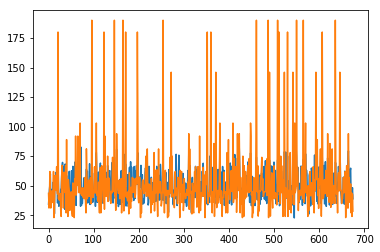

In [0]:
lineareg = LinearRegression(normalize =False)
cross = cross_val_score(lineareg, features, pm, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.3, random_state =42)

lineareg.fit(x_train, y_train)

pred = lineareg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


#(500 IMAGES LESS THAN WITH THE PREVIOUS REGRESSOR !!!!! )


In [0]:
joblib.dump(lineareg,'LINEAR_reg_WITH_TRANS.pkl')



['LINEAR_reg_WITH_TRANS.pkl']

In [0]:
print(((-1)*cross)**0.5)

[42.06059762 31.40440377 33.42732265]


In [0]:
d=[]
for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  k=y_test[i]-pred[i]
  if(k<=20 and k>=-20):
    d.append(k)


In [0]:
plt.plot(d)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_trai

12.922491630169047


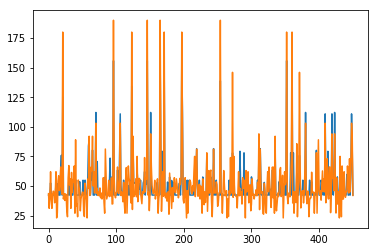

In [0]:
reg = RandomForestRegressor(max_depth=3) 
cross = cross_val_score(reg, features, pm, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


In [0]:
print(((-1)*cross)**0.5)

[43.01496345 31.81256785  8.86903355]


In [0]:
joblib.dump(reg,'AQImodelRandom_withouttrans.pkl')



['AQImodelRandom_withouttrans.pkl']

In [0]:
'''##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgito = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        
        
'''        

'##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS \n\nbucket = storage.bucket(app=app)\nblobs = bucket.list_blobs()\n\nimgito = [] #has all the minote pictures by their name \nctr=0\nmits = set()\nfor blob in blobs:\n  if blob.name.split(\'/\')[1]=="Lenovo.JPG" :\n    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:\n        blob.download_to_filename(\'/content/\' + "ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        imgito.append("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\') \n        print("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        ctr+=1\n        \n        \n'

In [0]:

for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  
  

In [0]:
def trans_deg(im):
#   im = cv2.imread(img)
#   im = cv2.resize(im, (256,256))
  B=np.zeros((256,256))
  D=np.zeros((256,256))
  C=np.zeros((256,256))
  # 3rd channel or im[2] has been split as b,g,r 

  b,g,r = cv2.split(im)

  for i in range(b.shape[0]):
    for j in range(b.shape[1]):
      D[i][j] = min(b[i][j], g[i][j], r[i][j])
      B[i][j] = max(b[i][j], g[i][j], r[i][j])
      C[i][j] = B[i][j] - D[i][j]

  d = np.sum(D)/float(np.size(D))
  b = np.sum(B)/float(np.size(B))
  c = b-d 
  A = (0.33)*max(np.ndarray.flatten(B)) + (0.66)*b
  
  x1=((A - d)/float(A)) 
  x2=(c/float(A))
  u = 10.127489
  v= -8.336512
  s = 0.13606234
  
  w = math.exp(-0.5*(u*x1 + v*x2)+s)
  
  return w

In [0]:
# def transmission(img, lt = 230, retMean = False):
#   ker = np.ones((3, 3))/9.0
#   imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   b, g, r = cv2.split(img)
#   hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
#   _, _, v = cv2.split(hsv)
#   v_blur = cv2.filter2D(v, -1, ker)
#   _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
#   sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
#   sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
#   building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
#   al = max(v_blur.flatten())
#   #Airlight Found. Now calculate Transmission Map
#   img_norm = img/float(al)
#   b, g, r = cv2.split(img_norm)
#   kernel = np.ones((3,3),np.uint8)
#   im_new = np.zeros((img.shape[0], img.shape[1]))
#   for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#       im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
#   dcp = cv2.erode(im_new, kernel, iterations = 1)
#   #ax[3].imshow(im_new, cmap = 'gray')
#   #ax[4].imshow(dcp, cmap = 'gray')
#   tr = np.ones((dcp.shape[0], dcp.shape[1]))
#   for i in range(dcp.shape[0]):
#     for j in range(dcp.shape[1]):
#       tr[i][j] = 1 - dcp[i][j]
#   #ax[1].imshow(tr, cmap = 'gray')
#   if retMean == False:
#     return tr
#   elif retMean == True:
#     return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)

cross = cross_val_score(gbrt, features, pm, scoring ='neg_mean_squared_error',cv=3)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

gbrt.fit(x_train, y_train)

y_pred = gbrt.predict(x_test)

errors = [mean_squared_error(y_val, y_pred)
for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(x_train, y_train) 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
print((cross*(-1))**0.5)

In [0]:
pred = gbrt_best.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
print(((-1)*cross)**0.5)